# Social dimension (Who)
* Misinformation detection exploiting user features
* Detection of malicious users: can we distinguish malicious from gullible users?
* Detection of superspreaders: abnormal rates of misinformation spread
* Detection of sources of misinformation: first users to share misinformation

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from utils import preprocess
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from gensim.models import Word2Vec

%matplotlib inline
sns.set(style="darkgrid")

## Load data users data

In [102]:
# users
df_users = pd.read_csv('data/2018/users.csv')

# credibility score with laplace smoothing

df_users['credibility'] = 1-df_users['misinformation']/(df_users['virals']+1)
df_users = df_users.rename(columns={"misinformation": "misinformations"})
print(df_users.columns)
df_users

Index(['id', 'groups', 'number_of_messages', 'texts', 'text_ratio', 'midia',
       'midia_ratio', 'virals', 'viral_ratio', 'repeated_messages',
       'repeated_messages_ratio', 'days_active', 'daily_mean', 'daily_std',
       'daily_median', 'daily_95', 'daily_outliers', 'degree_centrality',
       'strenght', 'viral_degree_centrality', 'viral_strenght',
       'misinformations', 'misinformation_degree_centrality',
       'misinformation_strenght', 'misinformation_ratio',
       'viral_misinformation_ratio', 'credibility'],
      dtype='object')


,id,groups,number_of_messages,texts,text_ratio,midia,midia_ratio,virals,viral_ratio,repeated_messages,...,degree_centrality,strenght,viral_degree_centrality,viral_strenght,misinformations,misinformation_degree_centrality,misinformation_strenght,misinformation_ratio,viral_misinformation_ratio,credibility
0,-3818310068976662355,1,4396,3742,0.851228,654,0.148772,24,0.005460,609,...,153,672588,153,3672,10,153,1530,0.002275,0.416667,0.600000
1,5782050016593913959,11,2332,972,0.416810,1360,0.583190,227,0.097341,363,...,1710,498161,1631,48057,58,1506,11907,0.024871,0.255507,0.745614
2,-2072140886659020977,3,2064,948,0.459302,1116,0.540698,243,0.117733,94,...,534,391490,534,46414,85,534,15800,0.041182,0.349794,0.651639
3,2839535797075678550,5,2020,1587,0.785644,433,0.214356,116,0.057426,258,...,895,644390,895,30154,25,866,6179,0.012376,0.215517,0.786325
4,170916900626840870,1,1810,828,0.457459,982,0.542541,111,0.061326,24,...,153,276930,153,16983,69,153,10557,0.038122,0.621622,0.383929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5359,-3685511676029813622,1,1,0,0.000000,1,1.000000,0,0.000000,0,...,166,166,0,0,0,0,0,0.000000,0.000000,1.000000
5360,-3687281691650946329,1,1,0,0.000000,1,1.000000,0,0.000000,0,...,188,188,0,0,0,0,0,0.000000,0.000000,1.000000
5361,4870300454101875011,1,1,1,1.000000,0,0.000000,0,0.000000,0,...,57,57,0,0,0,0,0,0.000000,0.000000,1.000000
5362,7020988212245908273,1,1,1,1.000000,0,0.000000,0,0.000000,0,...,91,91,0,0,0,0,0,0.000000,0.000000,1.000000


# Associate misinformation with information of the first user that shared

In [103]:

# dataset with labelled data
df = pd.read_csv('data/2018/fakeWhatsApp.BR_2018.csv')
df = df[df['misinformation']!= -1]

# select only labelled data
# df = pd.read_csv('data/2018/fakeWhatsApp.BR_2018.csv')
df = df[df['midia']==0]
df = df[df['misinformation']!=-1]

# sorting by time
def custom_time(data,hora):
    string = data + " " + hora
    return string

df['timestamp'] = df.apply(lambda x: custom_time(x['date'],x['hour']),axis=1)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%y %H:%M')
df.sort_values(by='timestamp',inplace=True)
df.drop_duplicates(subset='text', inplace = True)
df = df[['id','text','misinformation', 'timestamp']]
df['label'] = ['misinformation' if m == 1 else 'non-misinformation' for m in df['misinformation']]
print(len(df))
df.reset_index(drop=True,inplace=True)
df.head()

C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4,7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


6926


,id,text,misinformation,timestamp,label
0,6942577183305588053,"O dia em que ex-guerrilheiro, militantes e des...",1,2018-07-02 10:46:00,misinformation
1,-2072140886659020977,O nível dos jornalistas do programa Roda Viva ...,1,2018-07-02 10:50:00,misinformation
2,-5100443702615645928,*Atenção*\n\nPrecisamos da ajuda de todos você...,0,2018-07-02 11:03:00,non-misinformation
3,-1561843698204261697,"Gestão do colombiano na capital, imagina ele n...",1,2018-07-02 16:31:00,misinformation
4,-5876784761398352499,🛑🛑🛑🛑🛑🛑\nInterrompendo momentaneamente a conver...,1,2018-07-02 18:09:00,misinformation


## Get features from the user who shared the message

In [104]:
user_features = df_users.columns[1:]
df_user_features = pd.DataFrame(columns = user_features)

for u in df['id']:
    user = df_users[df_users['id']==u]
    values = user[user_features]
    df_user_features = pd.concat([df_user_features, user[user_features]])

df_user_features = df_user_features.reset_index(drop=True)

df = pd.concat([df,df_user_features], axis = 1)

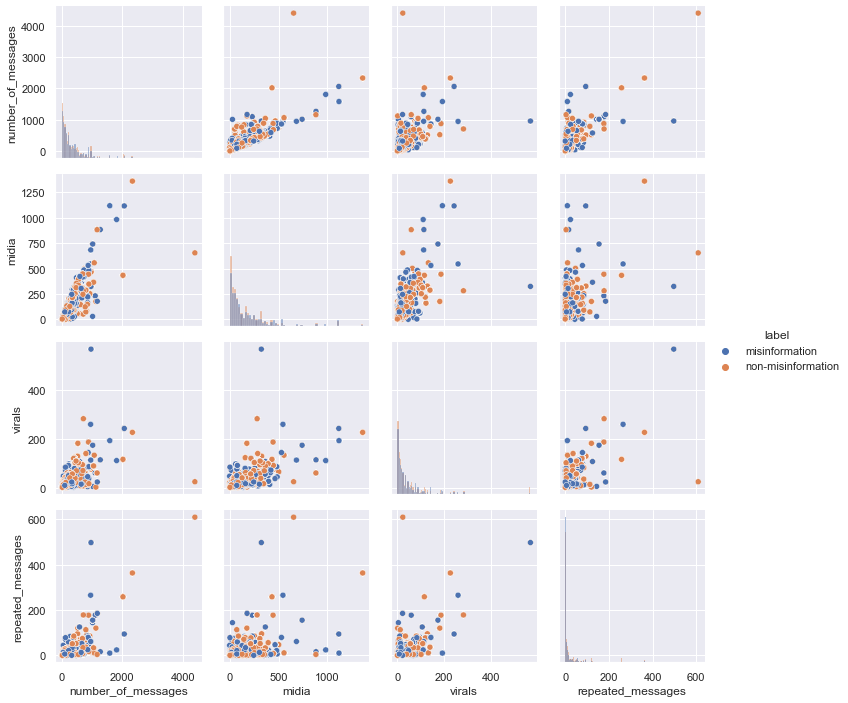

In [42]:
g = sns.PairGrid(df[['number_of_messages', 'midia',
                       'virals', 'repeated_messages','label']], 
                 hue = 'label')

g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

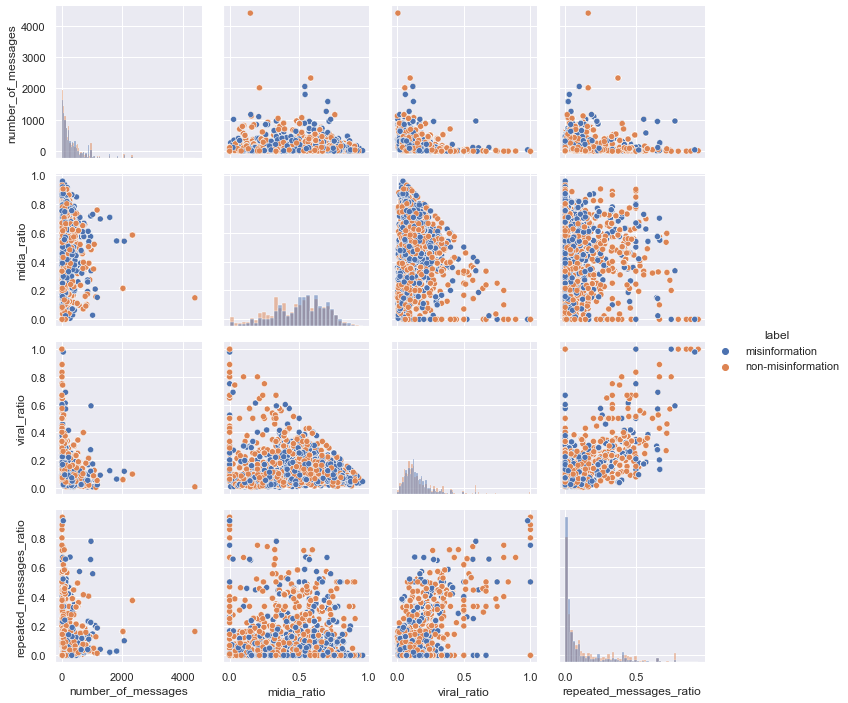

In [43]:
g = sns.PairGrid(df[['number_of_messages', 'midia_ratio',
                       'viral_ratio', 'repeated_messages_ratio','label']], 
                 hue = 'label')

g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

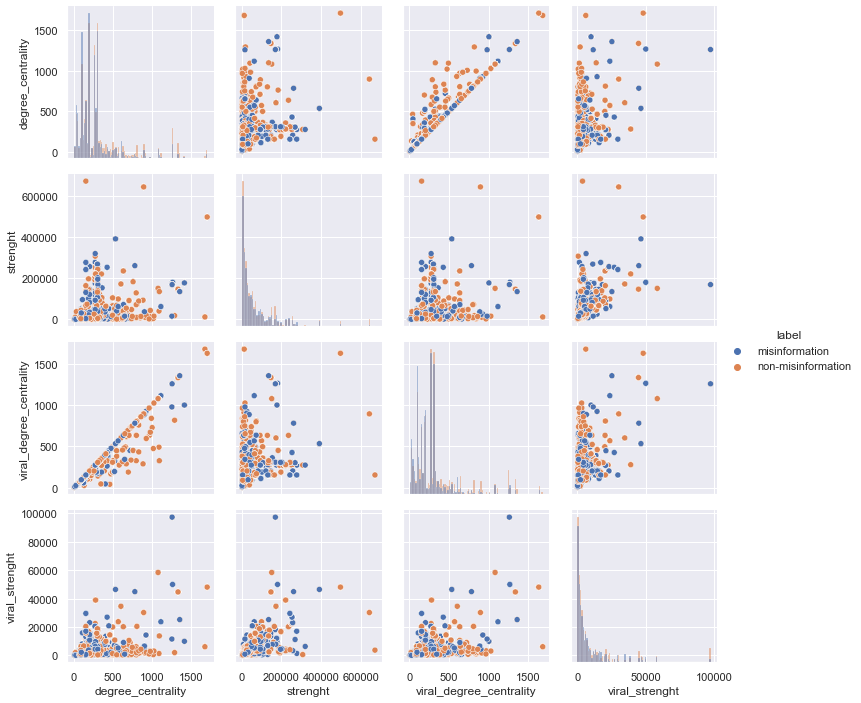

In [44]:
g = sns.PairGrid(df[['degree_centrality', 'strenght',
                     'viral_degree_centrality', 'viral_strenght', 'label']], 
                      hue = 'label', diag_sharey=False)

g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

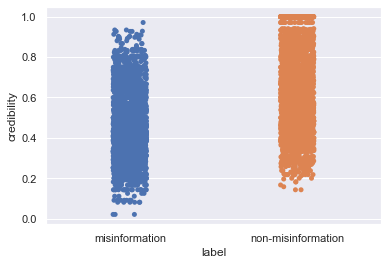

In [45]:
ax = sns.stripplot(x="label", y="credibility", data=df)

From this chart we observe that the credibility is not a good indicator to detect misinformation

C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


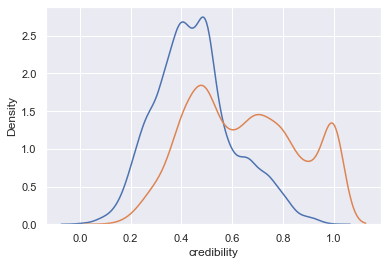

In [46]:
sns.distplot(df[df['label']=='misinformation']['credibility'], hist=False, rug=False)
sns.distplot(df[df['label']=='non-misinformation']['credibility'], hist=False, rug=False)

plt.show()

## Feature engineering

In [105]:
df.columns

Index(['id', 'text', 'misinformation', 'timestamp', 'label', 'groups',
       'number_of_messages', 'texts', 'text_ratio', 'midia', 'midia_ratio',
       'virals', 'viral_ratio', 'repeated_messages', 'repeated_messages_ratio',
       'days_active', 'daily_mean', 'daily_std', 'daily_median', 'daily_95',
       'daily_outliers', 'degree_centrality', 'strenght',
       'viral_degree_centrality', 'viral_strenght', 'misinformations',
       'misinformation_degree_centrality', 'misinformation_strenght',
       'misinformation_ratio', 'viral_misinformation_ratio', 'credibility'],
      dtype='object')

In [110]:
user_features = ['groups', 'number_of_messages', 'texts', 'text_ratio', 'midia', 'midia_ratio',
       'virals', 'viral_ratio', 'repeated_messages', 'repeated_messages_ratio',
       'days_active', 'daily_mean', 'daily_median', 'daily_95',
       'daily_outliers', 'degree_centrality', 'strenght',
       'viral_degree_centrality', 'viral_strenght']
X = df[user_features]
y = df['misinformation']
X.shape

(6926, 19)

In [111]:
# univariate analysis
X.std()

groups                         1.770462
number_of_messages           419.652180
texts                        234.832652
text_ratio                     0.190024
midia                        225.412812
midia_ratio                    0.190024
virals                        82.023044
viral_ratio                    0.132221
repeated_messages             75.256108
repeated_messages_ratio        0.176317
days_active                   26.614028
daily_mean                     7.293796
daily_median                   6.885890
daily_95                      18.787402
daily_outliers                 1.391171
degree_centrality            297.742565
strenght                   92697.043833
viral_degree_centrality      287.753385
viral_strenght             15352.680702
dtype: float64

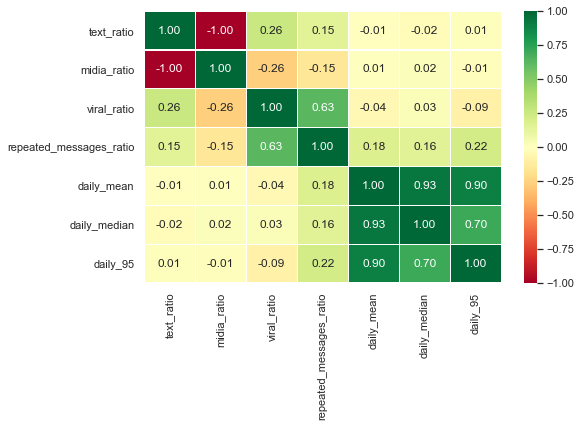

In [112]:
#get correlations of each features in dataset
corrmat = X.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(8,5))
#plot heat map
# sns.heatmap(df_similar, annot=True, fmt='.2f', linewidths=.1)
g=sns.heatmap(X[top_corr_features].corr(),annot=True, fmt='.2f', linewidths=.1,cmap="RdYlGn")

[0.01070088 0.04095216 0.05327574 0.07096074 0.06439377 0.04469179
 0.0269234  0.12021798 0.01226035 0.10204405 0.05582635 0.06248863
 0.0124979  0.08084407 0.03436139 0.04452161 0.06128031 0.03188249
 0.0698764 ]


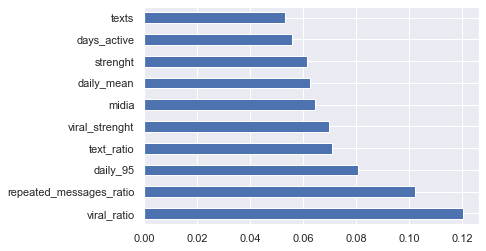

In [135]:
# feature importance

from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [138]:
list(feat_importances.nlargest(10).index)

['viral_ratio',
 'repeated_messages_ratio',
 'daily_95',
 'text_ratio',
 'viral_strenght',
 'midia',
 'daily_mean',
 'strenght',
 'days_active',
 'texts']

In [139]:
user_classification_features = list(feat_importances.nlargest(10).index)

# Exploiting user information to detect misinformation

In [140]:
# messages
df_train = pd.read_csv('data/2018/train-test/train.csv')
df_test = pd.read_csv('data/2018/train-test/test.csv')

In [141]:
# df_train['preprocessed_text'] = [preprocess(t) for t in df_train['text']]
# df_test['preprocessed_text'] = [preprocess(t) for t in df_test['text']]
# df_train.to_csv('data/2018/train-test/train.csv', index = False)
# df_test.to_csv('data/2018/train-test/test.csv', index = False)

In [142]:
# user_classification_features = ['groups', 'number_of_messages', 'midia_ratio',
#        'viral_ratio', , 'degree_centrality', 'strenght',
#        'viral_degree_centrality', 'viral_strenght']

#user_classification_features = ['midia_ratio', 'viral_ratio', 'repeated_messages_ratio']

def acquire_user_info(df_target, df_origin):   

    
    df_user_features = pd.DataFrame(columns = user_classification_features)

    for m in df_target['text']:
        user_info = df_origin[df_origin['text']==m]
        user_info.sort_values(by='timestamp')        
        user_info = user_info[0:1]
        user_info = user_info[user_classification_features] 
        df_user_features = pd.concat([df_user_features, user_info])
        
    df_user_features.reset_index(drop= True, inplace = True)
    df_target = pd.concat([df_target, df_user_features], axis = 1)
    return df_target

df_train = acquire_user_info(df_train, df)
df_test = acquire_user_info(df_test, df)    

In [143]:
df_train.head()

,text,misinformation,original,id_message,preprocessed_text,viral_ratio,repeated_messages_ratio,daily_95,text_ratio,viral_strenght,midia,daily_mean,strenght,days_active,texts
0,A ESQUERDA ACABOU. SAIBA POR QUÊ.\npor Stephen...,1,1,0,esquerdo acabar saber que \n stephen kanitz ar...,0.177305,0.032258,7.0,0.439716,1425,79,1.205128,8037,117,62
1,Leiam esse artigo \n\n\nA ESQUERDA ACABOU. SAI...,1,0,0,ler artigo \n \n \n esquerdo acabar saber que ...,0.397472,0.412993,29.3,0.605337,58364,281,9.128205,150659,78,431
2,A ESQUERDA ACABOU. SAIBA POR QUÊ?\npor Stephen...,1,0,0,esquerdo acabar saber que ? \n stephen kanitz ...,0.142268,0.030769,38.6,0.268041,6279,355,13.857143,44135,35,130
3,A ESQUERDA ACABOU. SAIBA POR QUÊ.\npor Stephen...,1,0,0,esquerdo acabar saber que \n stephen kanitz \n...,0.069252,0.102190,15.0,0.379501,6750,224,4.878378,97470,74,137
4,A ESQUERDA ACABOU. SAIBA POR QUÊ.\npor Stephen...,1,0,0,esquerdo acabar saber que \n stephen kanitz \n...,0.190244,0.025641,11.3,0.380488,5772,127,1.737288,30340,118,78


In [144]:
# include viral strenght
# X_train = df_train[['midia_ratio','viral_ratio', 'viral_strenght']].to_numpy()
# X_test = df_test[['midia_ratio','viral_ratio', 'viral_strenght']].to_numpy()
# y_train = df_train['misinformation']
# y_test = df_test['misinformation']
# X_train,X_test = utils.z_score(X_train,X_test)
# X_train.shape


X_train = df_train[user_classification_features].to_numpy()
X_train = np.array(X_train, dtype=np.float64)
X_test = df_test[user_classification_features].to_numpy()
X_test = np.array(X_test, dtype=np.float64)
y_train = df_train['misinformation']
y_test = df_test['misinformation']

X_train_u, X_test_u = utils.z_score(X_train, X_test)
X_train, X_test = utils.z_score(X_train, X_test)

print('train', X_train.shape)
print('test', X_test.shape)

# with open('train_user_features.npy', 'wb') as f:
#     np.save(f, X_train)
    
# with open('test_user_features.npy', 'wb') as f:
#     np.save(f, X_test)

train (6233, 10)
test (1574, 10)


logistic regression + user info
0.45
              precision    recall  f1-score   support

           0       0.67      0.46      0.54       834
           1       0.55      0.74      0.63       740

    accuracy                           0.59      1574
   macro avg       0.61      0.60      0.59      1574
weighted avg       0.61      0.59      0.58      1574

AUC:  0.6069819819819819


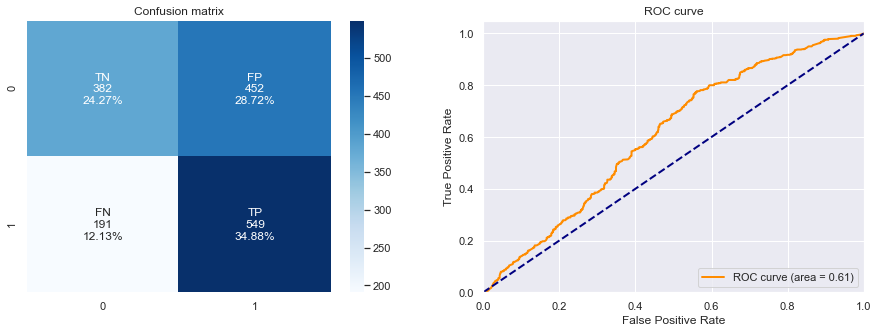

0,591
0,457
0,548
0,741
0,630
0,606


(0.5914866581956798,
 0.45700071073205406,
 0.5484515484515484,
 0.7418918918918919,
 0.6306720275703618,
 0.6069819819819819)

In [145]:
print('logistic regression + user info')
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_prob = lr.predict_proba(X_test)[:,1]
y_prob_train = lr.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + user
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
ACC: 0.579
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
ACC: 0.556
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
ACC: 0.558
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
ACC: 0.569
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
ACC: 0.562

--------------------
BEST PARAMETERS (validation AUC = 0.579)
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
--------------------
0.5
              precision    recall  f1-score   support

           0       0.61      0.57      0.59       834
           1       0.55      0.58      0.56       740

    accuracy                           0.58      1574
   macro avg       0.58      0.58      0.58      1574
weighted avg       0.58      0.58      0.58      1574

AUC:  0.6034440015555124


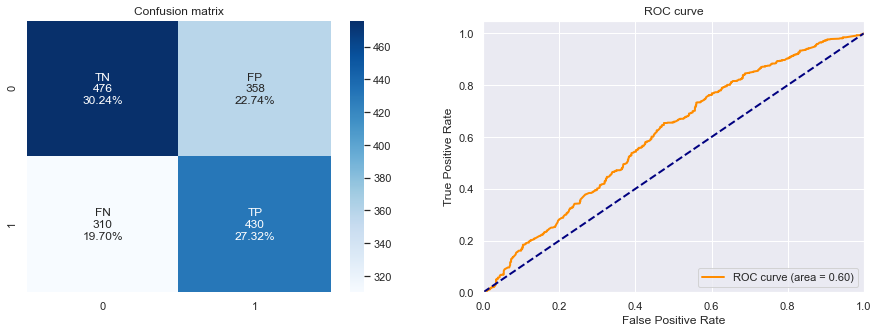

0,575
0,412
0,545
0,581
0,562
0,603


(0.5756035578144854,
 0.41234567901234576,
 0.5456852791878173,
 0.581081081081081,
 0.5628272251308901,
 0.6034440015555124)

In [146]:
print('mlp + user')
hl,bs,al,lri = utils.random_search_mlp(X_train,y_train,n_iter=5)
clf = utils.optimized_mlp(hl,bs,al,lri)
clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

# Combining with text

## User + Word2Vec

In [147]:
w2v = Word2Vec.load("data/2018/word2vec.model")
X_train_w = utils.vectorize_corpus(w2v, df_train['preprocessed_text'])
X_test_w = utils.vectorize_corpus(w2v, df_test['preprocessed_text'])

In [148]:
X_train = np.concatenate((X_train_w, X_train_u), axis=1)
X_test = np.concatenate((X_test_w, X_test_u), axis=1)

logistic regression + user info + w2v
0.47
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       834
           1       0.70      0.76      0.73       740

    accuracy                           0.74      1574
   macro avg       0.74      0.74      0.74      1574
weighted avg       0.74      0.74      0.74      1574

AUC:  0.8075636787867003


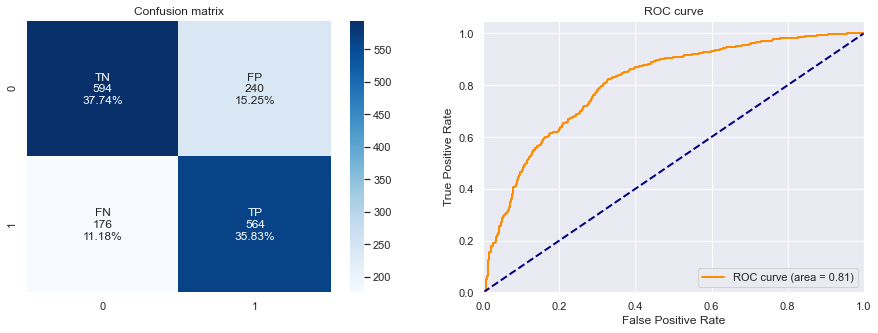

0,735
0,259
0,701
0,762
0,730
0,807


(0.735705209656925,
 0.25935162094763087,
 0.7014925373134329,
 0.7621621621621621,
 0.7305699481865284,
 0.8075636787867003)

In [149]:
print('logistic regression + user info + w2v')
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_prob = lr.predict_proba(X_test)[:,1]
y_prob_train = lr.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + user + w2v
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
ACC: 0.803
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
ACC: 0.777
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
ACC: 0.816
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
ACC: 0.744
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
ACC: 0.804
5 
hidden layers: (200, 25, 50); alpha: 0.00000; learning rate: 0.06823; batch: 150
ACC: 0.530
6 
hidden layers: (200,); alpha: 0.00001; learning rate: 0.02102; batch: 250
ACC: 0.821
7 
hidden layers: (25, 25, 125); alpha: 0.00030; learning rate: 0.00686; batch: 250
ACC: 0.782
8 
hidden layers: (125, 250); alpha: 0.00006; learning rate: 0.00691; batch: 100
ACC: 0.811
9 
hidden layers: (200, 250); alpha: 0.00757; learning rate: 0.00911; batch: 200
ACC: 0.821

--------------------
BEST PARAMETERS (validation AUC = 0.821)
h

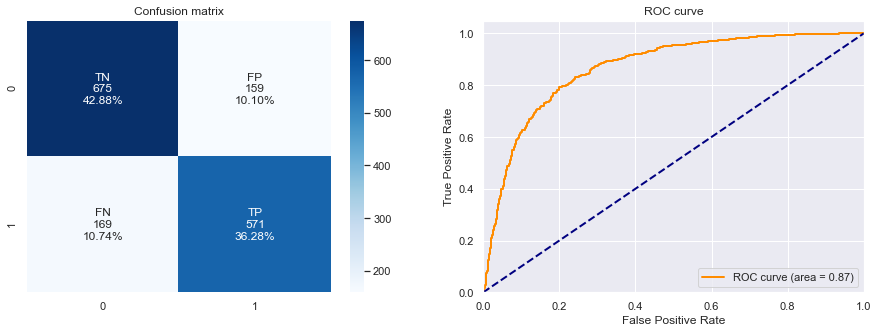

0,791
0,195
0,782
0,771
0,776
0,867


(0.7916137229987293,
 0.19547079856972593,
 0.7821917808219178,
 0.7716216216216216,
 0.7768707482993198,
 0.8670247585715212)

In [150]:
print('mlp + user + w2v')
hl,bs,al,lri = utils.random_search_mlp(X_train,y_train,n_iter=10)
clf = utils.optimized_mlp(hl,bs,al,lri)
clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

## TF-IDF + users

In [151]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
tfidf = TfidfVectorizer(max_features = None, ngram_range = (1,1), #(1,3)  #15000
                             lowercase = False, token_pattern = r'[^\s]+', binary=False)

tfidf.fit(df_train['preprocessed_text'])   
X_train_tfidf = tfidf.transform(df_train['preprocessed_text']).todense()
X_test_tfidf = tfidf.transform(df_test['preprocessed_text']).todense()
X_train_tfidf.shape

(6233, 17525)

In [152]:
X_train = np.concatenate((X_train_tfidf, X_train_u), axis=1)
X_test = np.concatenate((X_test_tfidf, X_test_u), axis=1)

logistic regression + user info + tfidf
0.49
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       834
           1       0.79      0.77      0.78       740

    accuracy                           0.80      1574
   macro avg       0.80      0.79      0.80      1574
weighted avg       0.80      0.80      0.80      1574

AUC:  0.8656102145310779


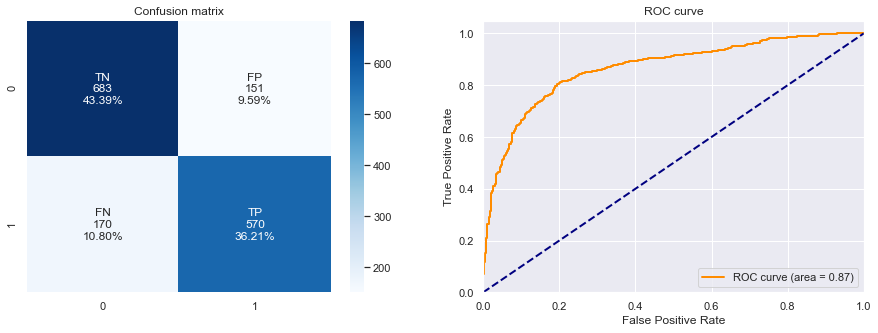

0,796
0,190
0,790
0,770
0,780
0,865


(0.7960609911054638,
 0.1902786010669827,
 0.7905686546463245,
 0.7702702702702703,
 0.7802874743326489,
 0.8656102145310779)

In [153]:
print('logistic regression + user info + tfidf')
lr = LogisticRegression(max_iter=200)
lr.fit(X_train, y_train)

y_prob = lr.predict_proba(X_test)[:,1]
y_prob_train = lr.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + user + tfidf
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
ACC: 0.853
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
ACC: 0.840
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
ACC: 0.865
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
ACC: 0.859
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
ACC: 0.867
5 
hidden layers: (200, 25, 50); alpha: 0.00000; learning rate: 0.06823; batch: 150
ACC: 0.862
6 
hidden layers: (200,); alpha: 0.00001; learning rate: 0.02102; batch: 250
ACC: 0.832
7 
hidden layers: (25, 25, 125); alpha: 0.00030; learning rate: 0.00686; batch: 250
ACC: 0.877
8 
hidden layers: (125, 250); alpha: 0.00006; learning rate: 0.00691; batch: 100
ACC: 0.878
9 
hidden layers: (200, 250); alpha: 0.00757; learning rate: 0.00911; batch: 200
ACC: 0.880

--------------------
BEST PARAMETERS (validation AUC = 0.880)

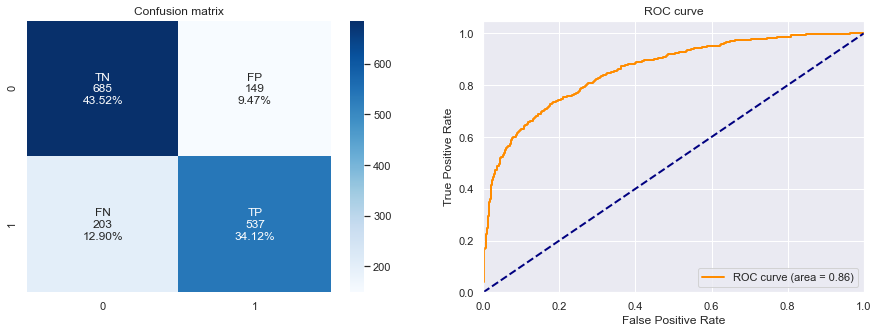

0,776
0,204
0,782
0,725
0,753
0,859


(0.7763659466327827,
 0.20441347270615562,
 0.782798833819242,
 0.7256756756756757,
 0.7531556802244039,
 0.8591224317843024)

In [154]:
print('mlp + user + tfidf')
hl,bs,al,lri = utils.random_search_mlp(X_train,y_train,n_iter=10)
clf = utils.optimized_mlp(hl,bs,al,lri)
clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)